---

# Data Mining:<br>Statistical Modeling and Learning from Data

## Dr. Ciro Cattuto<br>Dr. Laetitia Gauvin<br>Dr. André Panisson

### Exercises - Learning Curves, Bias-Variance

---

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Illustration of the Bias-Variance Tradeoff with Scikit-Learn

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit

In [2]:
def test_func(x, err):
    y = np.sin(x*np.pi*2)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

In [3]:
def make_data(n=40, error=0.1, random_seed=1):
    # randomly sample the data
    np.random.seed(random_seed)
    X = np.random.random(n)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

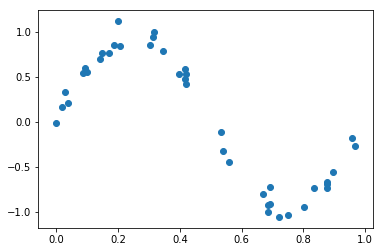

In [4]:
X, y = make_data(40)
plt.scatter(X.ravel(), y)

Now say we want to perform a regression on this data.  Let's use the built-in linear regression function to compute a fit:

mean squared error: 0.19852350003


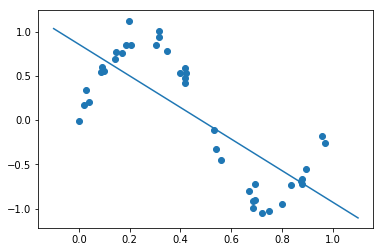

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
print "mean squared error:", metrics.mean_squared_error(model.predict(X), y)

We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model is **biased**, or that it **under-fits** the data.

Let's try to improve this by creating a more complicated model.  We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs.  Let's make this easier by creating a quick PolynomialRegression estimator:

In [6]:
class PolynomialRegression(LinearRegression):
    """Simple Polynomial Regression to 1D data"""
    def __init__(self, degree=1, **kwargs):
        self.degree = degree
        LinearRegression.__init__(self, **kwargs)
        
    def fit(self, X, y):
        if X.shape[1] != 1:
            raise ValueError("Only 1D data valid here")
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.fit(self, Xp, y)
        
    def predict(self, X):
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.predict(self, Xp)

Now we'll use this to fit a quadratic curve to the data.

mean squared error: 0.189712231242


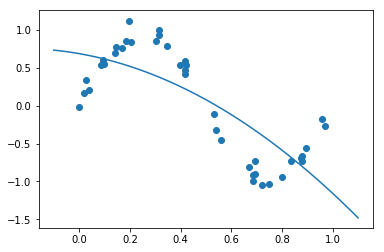

In [7]:
model = PolynomialRegression(degree=2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
print "mean squared error:", metrics.mean_squared_error(model.predict(X), y)

This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

mean squared error: 0.00284929396435


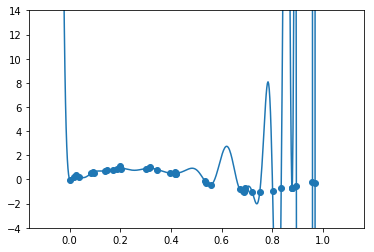

In [8]:
model = PolynomialRegression(degree=60)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.ylim(-4, 14)
print "mean squared error:", metrics.mean_squared_error(model.predict(X), y)

When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

## Detecting over-fitting
Clearly, computing the error on the training data is not enough (we saw this previously).  But computing the *validation error* can help us determine what's going on: in particular, comparing the training error and the validation error can give you an indication of how well your data is being fit.

Let's do this:

/Users/panisson/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Text(0,0.5,u'MSE')

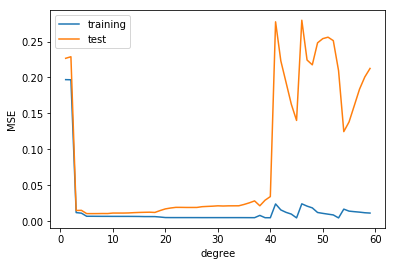

In [9]:
from sklearn import cross_validation

degrees = np.arange(1, 60)

X, y = make_data(100)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

training_error = []
test_error = []
mse = metrics.mean_squared_error

for d in degrees:
    model = PolynomialRegression(d).fit(X_train, y_train)
    training_error.append(mse(model.predict(X_train), y_train))
    test_error.append(mse(model.predict(X_test), y_test))
    
# note that the test error can also be computed via cross-validation
plt.plot(degrees, training_error, label='training')
plt.plot(degrees, test_error, label='test')
plt.legend()
plt.xlabel('degree')
plt.ylabel('MSE')

(-1.5, 1.5)

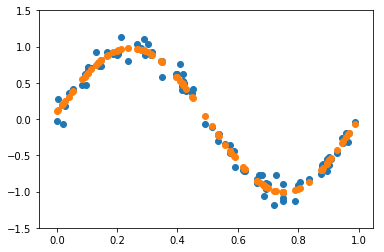

In [10]:
d = degrees[np.argmin(test_error)]

model = PolynomialRegression(d).fit(X_train, y_train)
y_pred = model.predict(X)

plt.scatter(X.ravel(), y)
plt.scatter(X.ravel(), y_pred)
plt.ylim(-1.5, 1.5)

# Illustration of dependency of $E_{\mathbf{in}}$ and $E_{\mathbf{out}}$ in relation to $N$

For this section, we will see how a classification model behaves when we increase the number of samples. We will work on a 2D classification problem, and the results generalize to higher dimensional datasets.

We will generate 1000 samples from a bivariate Gaussian distribution $\mathcal{ N } ((2, 0)^T , I)$ and will label this class **RED**. Similarly, 1000 more are drawn from $ \mathcal{N} ((0, 2)^T , I)$ and are labeled **GREEN**.

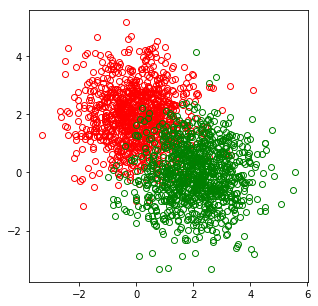

In [11]:
np.random.seed(2)
nr_samples = 2000

# Generate samples from two bivariate Gaussian distributions
samples_red   = np.random.multivariate_normal(mean=(0,2), cov=np.identity(2), size=nr_samples/2)
samples_green = np.random.multivariate_normal(mean=(2,0), cov=np.identity(2), size=nr_samples/2)

# Join the red and green datasets as X and the class definitions as y
X = np.concatenate([samples_red, samples_green])
y = np.zeros(nr_samples, dtype=int)
y[nr_samples/2:] = 1

# plot the red and green class points
figure(num=None, figsize=(5, 5))
plot(samples_red[:,0], samples_red[:,1], 'o', mec='r', mfc='none')
plot(samples_green[:,0], samples_green[:,1], 'o', mec='g', mfc='none')

A 2D classification can be accomplished within Scikit-Learn with the `sklearn.linear_model` module.
We will divide the dataset in two parts: a train dataset and a test dataset. This can be accomplished within Scikit-Learn with the function `train_test_split` from the package `cross_validation`.

In [12]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=42)

Let's build a Logistic Regression model and evaluate both $E_{\mathbf{in}}$ and $E_{\mathbf{out}}$ for the instance trained with the train set, where the error is defined as the mean absolute error:

In [13]:
from sklearn import linear_model, metrics

def evaluate(X_train, y_train, X_test, y_test):
    model = linear_model.LogisticRegression()
    model.fit(X_train, y_train)

    ein = metrics.mean_absolute_error(model.predict(X_train), y_train)
    eout = metrics.mean_absolute_error(model.predict(X_test), y_test)
    
    return ein, eout

print evaluate(X_train, y_train, X_test, y_test)

(0.075999999999999998, 0.081000000000000003)


Then let's create a function that runs the evaluation for a number of realizations, but in every realization selects randomly from the training set a fixed number of samples (`n_samples`) and evaluates the Logistic Regression:

In [14]:
def evaluate_many(X_train, y_train, X_test, y_test, n_samples=100, n_realizations=100):
    
    n_max = X_train.shape[0]
    ein_n = []
    eout_n = []
    
    for i in range(n_realizations):
    
        f = np.random.choice(n_max, n_samples, replace=False)
        X_train_filtered = X_train[f]
        y_train_filtered = y_train[f]
        
        ein, eout = evaluate(X_train_filtered, y_train_filtered, X_test, y_test)
        
        ein_n.append(ein)
        eout_n.append(eout)
    
    return np.mean(ein_n), np.mean(eout_n)

print evaluate_many(X_train, y_train, X_test, y_test, n_samples=50)

(0.066400000000000001, 0.086029999999999981)


Finally, we will evaluate the Logistic Regression model for different datasets, fixing the number of samples:

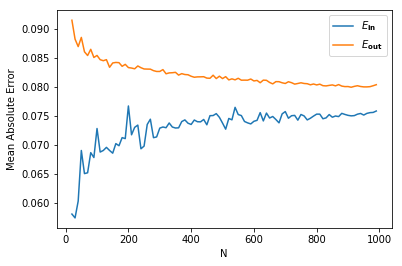

In [15]:
random.seed(2)

n_list = arange(20,1000,10)

n_max = X_train.shape[0]

ein_list = []
eout_list = []

for n in n_list:
    
    ein_n, eout_n = evaluate_many(X_train, y_train,
                                  X_test, y_test, n_samples=n)
    
    ein_list.append(ein_n)
    eout_list.append(eout_n)
    
plot(n_list, ein_list, label="$E_{\mathbf{in}}$")
plot(n_list, eout_list, label="$E_{\mathbf{out}}$")
xlabel('N')
ylabel('Mean Absolute Error')
legend();

# Exercise: Bias and Variance on a sine function

For this exercise, we will produce data from a target function $f(x) = \sin(\pi x)$.

For $N$ times, we will choose two points from the interval $[-1,1]$ and evaluate $f(x)$ for these points.
Then, we will create two classes of functions: $h_0$ and $h_1$. The functions in $h_0$ are linear regressions of the type $y = b$, while $h_1$ are linear regressions of the type $y = ax + b$.

In [16]:
f = lambda x: sin(pi*x)
N = 100
h0 = []
h1 = []

for i in  range(N):
    d = random.uniform(-1, 1, 2) 
    y = f(d)
    
    g0 = poly1d(polyfit(d, y, 0))
    h0.append(g0)
    
    g1 = poly1d(polyfit(d, y, 1))
    h1.append(g1)

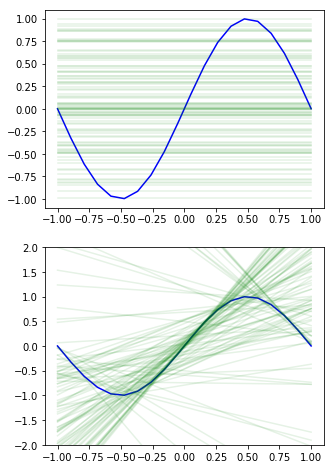

In [17]:
fig = plt.figure(figsize=(5,8))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

x = linspace(-1, 1, 20)

ax1.plot(x, f(x), 'b')
ylim(-2,2)
ax2.plot(x, f(x), 'b')
ylim(-2,2)

for i in  range(N):
    ax1.plot(x, h0[i](x), 'g', alpha=0.1)
    ax2.plot(x, h1[i](x), 'g', alpha=0.1)

In the next, you will calculate the **bias** and **variance** for the two classes of functions: $h_0$ and $h_1$.

For the solution, proceed with the following steps:

1. Create a list `x` of 100 values between -1 and 1. These values will be used to evaluate the two classes of functions at different points.
2. Create a list of values $g_0$ that represents the average of the functions $h_0$ in each point of `x`:
    $${g_0}_k = \frac{1}{N}\sum_i^N{{h_0}_i(x_k)}$$
3. Create a list of values $g_1$ that represents the average of the functions $h_1$ in each point of `x`:
    $${g_1}_k = \frac{1}{N}\sum_i^N{{h_1}_i(x_k)}$$
4. Assign to $\mathbf{bias}_0$ the average of the squares of the differences between $g_0$ and $f$:
    $$\mathbf{bias}_0 = \frac{1}{N}\sum_i^N{\left({g_0}(x_i) - f(x_i)\right)^2}$$
5. Assign to $\mathbf{bias}_1$ the average of the squares of the differences between $g_1$ and $f$:
    $$\mathbf{bias}_1 = \frac{1}{N}\sum_i^N{\left({g_1}(x_i) - f(x_i)\right)^2}$$
6. Assign to a matrix $\mathbf{var}_0$ the the differences between the functions $h_0$ and $g_0$ in each point of `x`:
    $${\mathbf{var}_0}_{ij} = {\left({h_0}_i(x_j) - g_0(x_j)\right)^2}$$
7. Assign to a matrix $\mathbf{var}_1$ the differences between the functions $h_1$ and $g_1$ in each point of `x`:
    $${\mathbf{var}_1}_{ij} = {\left({h_1}_i(x_j) - g_1(x_j)\right)^2}$$

In [18]:
g0 = np.mean(np.array([g(x) for g in h0]), axis=0)
g1 = np.mean(np.array([g(x) for g in h1]), axis=0)

bias0 = np.mean((g0 - f(x))**2)
bias1 = np.mean((g1 - f(x))**2)

var0 = [(g(x) - g0)**2 for g in h0]
var1 = [(g(x) - g1)**2 for g in h1]

print "H0:", bias0 + mean(var0)
print "H1:", bias1 + mean(var1)

H0: 0.72118621786
H1: 2.1272175343


(-3, 3)

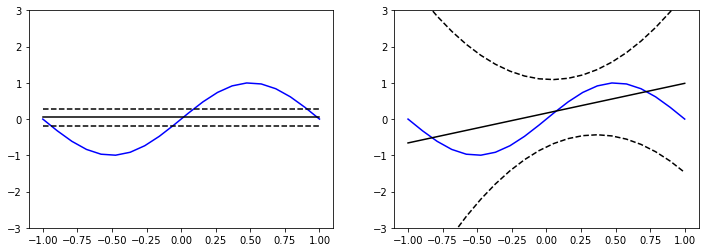

In [19]:
fig = figure(figsize=(12,4))

x = linspace(-1, 1, 20)
fx = sin(pi*x)

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x, fx, 'b')
ax1.plot(x, g0, 'k')
ax1.plot(x, g0-mean(var0, axis=0),'k--')
ax1.plot(x, g0+mean(var0, axis=0),'k--')
ylim(-3, 3)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(x, fx, 'b')
ax2.plot(x, g1, 'k')
ax2.plot(x, g1-mean(var1, axis=0),'k--')
ax2.plot(x, g1+mean(var1, axis=0),'k--')
ylim(-3, 3)